## Predicting cyclist traffic in Paris

## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

Our notebook is organised as so, and we try to have a look at the data before jumping into model selection.

Introduction EDA
Look at top Station
Temporal Analysis:
- Seasonal look (Overview)
- Rush Hours
- Weekdays and Week-ends
- Bank Holidays vs working days
- School Holidays (vacances scolaires) and working days

The idea of using Ridge was to use a model where less important parameters are squished to see which parameters are really important, we then are going to use them with a RandomForest. Why a RF will be explained later in this notebook.
Model Selection:
- Trying out a simple Ridge regression with feature engineering on temporal data (hours_cos is a good predictor)
- Gridsearch and Hyperparameters selection for Ridge
- Adding weather data
- Ridge Limitations
- Trying out RandomForest

Let's start by a really quick EDA, then we'll think about adding potentially relevent external data points to enrich our analysis.

## Exploratory Data Analysis

In [17]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import datetime

In [27]:
df = pd.read_parquet(Path("data")/ "train.parquet")
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [57]:
#  Basic Overview
print("=== Basic Information ===")
print(df.info())
print("\n=== First few rows ===")
print(df.head())
print("\n=== Basic Statistics ===")
print(df.describe())

=== Basic Information ===
<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             

In [58]:
# Unique Values Analysis
print("\n=== Number of unique values per column ===")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")


=== Number of unique values per column ===
counter_id: 56 unique values
counter_name: 56 unique values
site_id: 30 unique values
site_name: 30 unique values
bike_count: 998 unique values
date: 8974 unique values
counter_installation_date: 22 unique values
coordinates: 30 unique values
counter_technical_id: 30 unique values
latitude: 30 unique values
longitude: 30 unique values
log_bike_count: 998 unique values


In [59]:
(
    df.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

C:\Users\alexa\AppData\Local\Temp\ipykernel_5904\2792127300.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


In [ ]:
# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.day_name()
df['is_weekend'] = df['date'].dt.weekday >= 5

Kind of as expected people take velibs to go back and from work mostly (so around 7 until 4 or 5). So it would be worthwile to add in holidays in our analysis as external data because I think they can have a huge impact on the ending.

Maybe look up some stats/sondages about velib uses and when/why/who uses velib as part of our EDA.

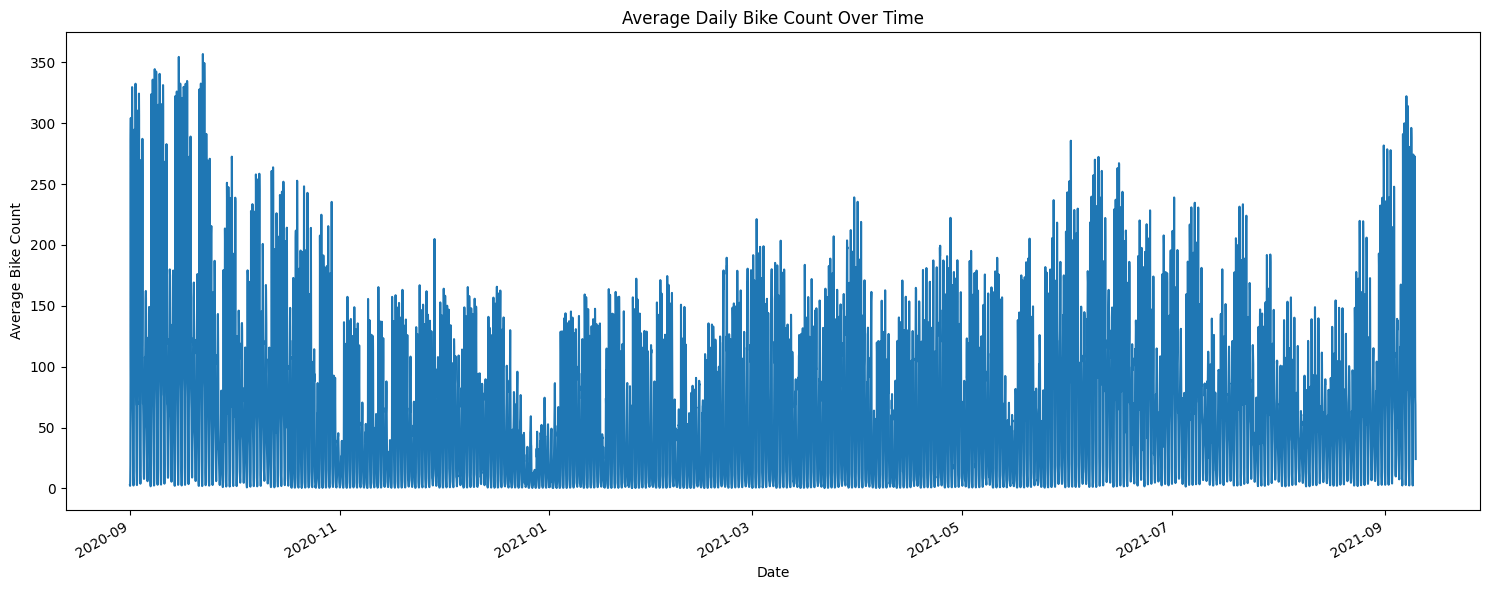

In [61]:

# Time Series View
plt.figure(figsize=(15, 6))
daily_counts = df.groupby('date')['bike_count'].mean()
daily_counts.plot()
plt.title('Average Daily Bike Count Over Time')
plt.xlabel('Date')
plt.ylabel('Average Bike Count')
plt.tight_layout()
plt.show()


This seems to confirm my view, for example we can look at around end of decemeber most people are in vacation, it's cold and there is a sharp drop in velib use...

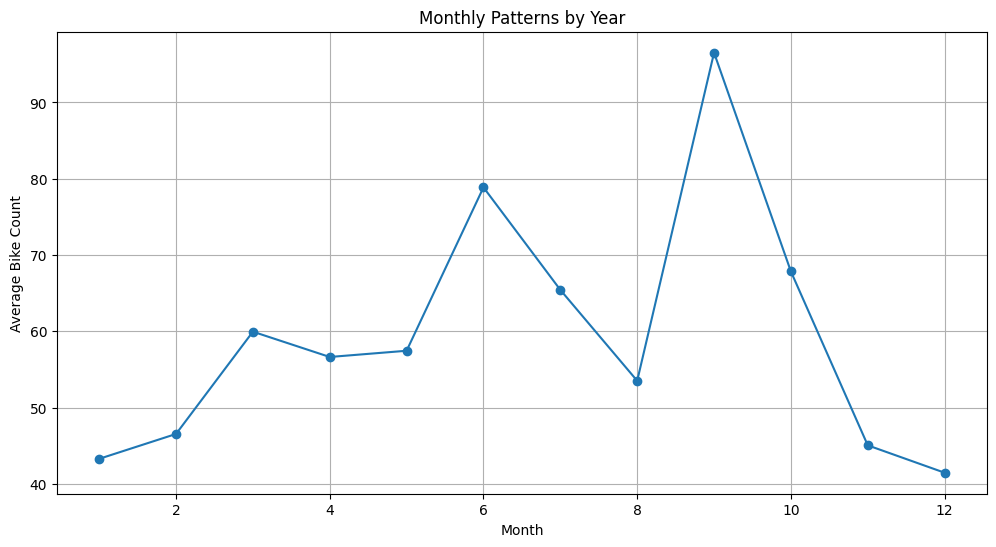

In [62]:
# Monthly patterns
monthly_traffic = df.groupby(['month'])['bike_count'].mean()
plt.figure(figsize=(12, 6))
monthly_traffic.T.plot(marker='o')
plt.title('Monthly Patterns by Year')
plt.xlabel('Month')
plt.ylabel('Average Bike Count')
plt.grid(True)
plt.show()


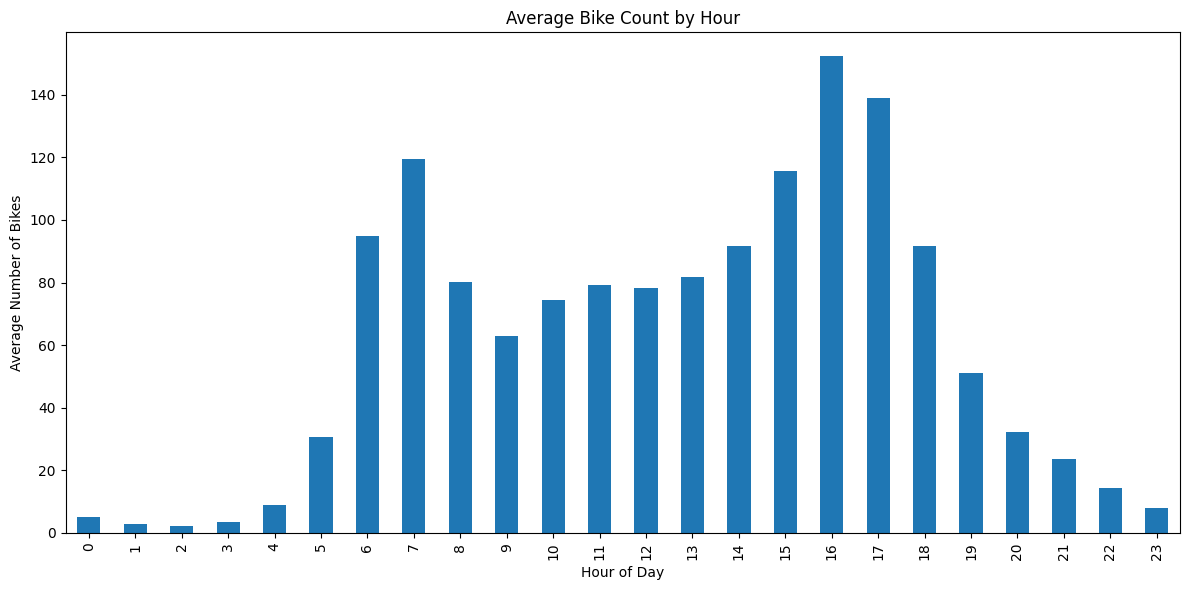

In [63]:
# Plot hourly patterns
plt.figure(figsize=(12, 6))
hourly_avg = df.groupby('hour')['bike_count'].mean()
hourly_avg.plot(kind='bar')
plt.title('Average Bike Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.tight_layout()
plt.show()

Velib are used for commuting to working  looking at the peak hours. Let's verify that by looking at weekdays/weekends and weekdays/holidays patterns an important difference will indicate different use.

<Figure size 1200x600 with 0 Axes>

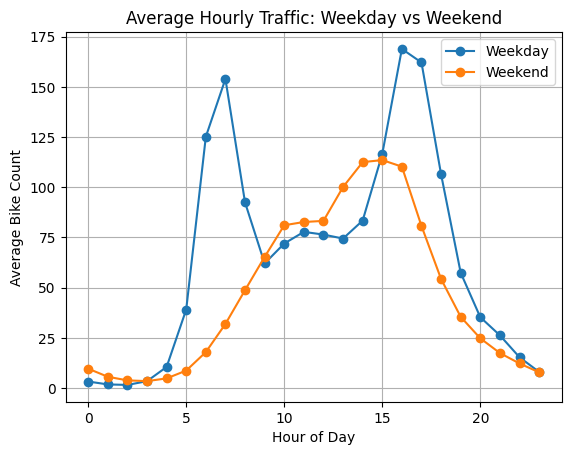

In [64]:
# Daily Patterns
hourly_traffic = df.groupby(['hour', 'is_weekend'])['bike_count'].mean().unstack()
plt.figure(figsize=(12, 6))
hourly_traffic.plot(marker='o')
plt.title('Average Hourly Traffic: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Average Bike Count')
plt.legend(['Weekday', 'Weekend'])
plt.grid(True)
plt.show()

In [65]:
import requests

def get_holidays_from_api(start_year=2020, end_year=2022):
    holidays = []
    for year in range(start_year, end_year):
        url = f"https://calendrier.api.gouv.fr/jours-feries/metropole/{year}.json"
        response = requests.get(url)
        if response.status_code == 200:
            year_holidays = response.json()
            for date, name in year_holidays.items():
                holidays.append({'date': date, 'holiday_name': name})

    return pd.DataFrame(holidays)

In [66]:
holidays = get_holidays_from_api()

In [67]:
holidays['date'] = pd.to_datetime(holidays['date'])
holidays.dtypes

date            datetime64[ns]
holiday_name            object
dtype: object

In [68]:
df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)

<Figure size 1500x600 with 0 Axes>

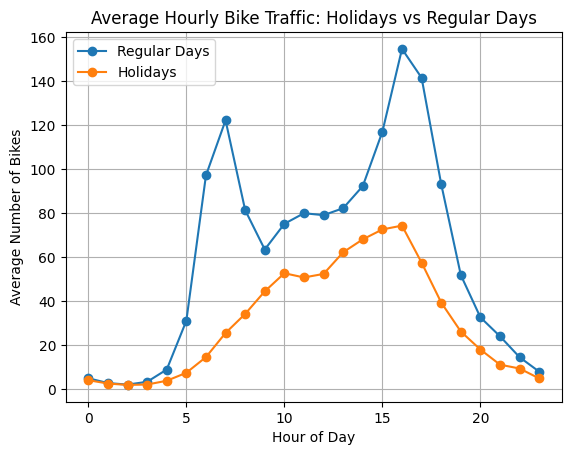

In [69]:
# Compare traffic patterns
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays'])
plt.grid(True)
plt.show()

The difference is even more important than with weekdays vs weekends.

In [70]:
# Read the holidays data
holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')
holidays_sco.head()

,date
0,2017-10-20
1,2017-10-21
2,2017-10-22
3,2017-10-23
4,2017-10-24


In [71]:
holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

In [72]:
holidays_sco = holidays_sco[holidays_sco['date'].dt.year == 2021]
holidays_sco = holidays_sco.drop_duplicates()
len(holidays_sco)

133

<Figure size 1500x600 with 0 Axes>

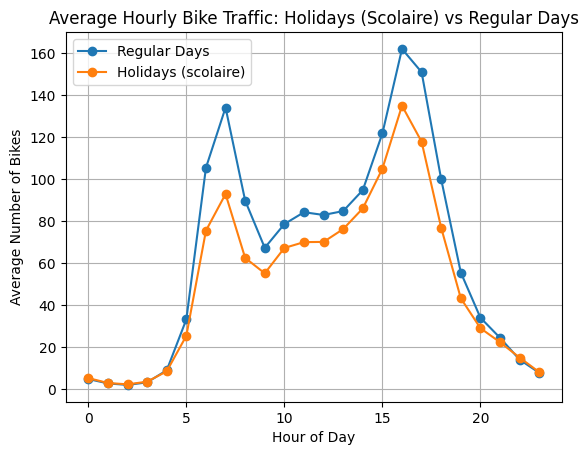

In [73]:
# 2. Compare traffic patterns vacances scolaires vs not vacances scolaires
plt.figure(figsize=(15, 6))
comparison = df.groupby(['hour', 'is_holiday_sco'])['bike_count'].mean().unstack()
comparison.plot(marker='o')
plt.title('Average Hourly Bike Traffic: Holidays (Scolaire) vs Regular Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Bikes')
plt.legend(['Regular Days', 'Holidays (scolaire)'])
plt.grid(True)
plt.show()

The impact is less pronounced for holidays_sco than for bank holidays, indeed french childrens have quite a lot of holiday and adults don't always take their holidays at the same time (and have less). The information still seems to hold value so we will use it in our models.

We are considering using Cosine transformation to my data to better capture cyclical patterns. This is the analysis obtained (I decided not too keep the code because we will be dropping the use of most of these features)

We tried this encoding and checked its correlation with log_bikes

 Add cyclical encoding for hour (24-hour cycle)
- df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
- df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

 Add cyclical encoding for month (12-month cycle)
- df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
- df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

Add cyclical encoding for day_of_week (7-day cycle)
- df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
- df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)

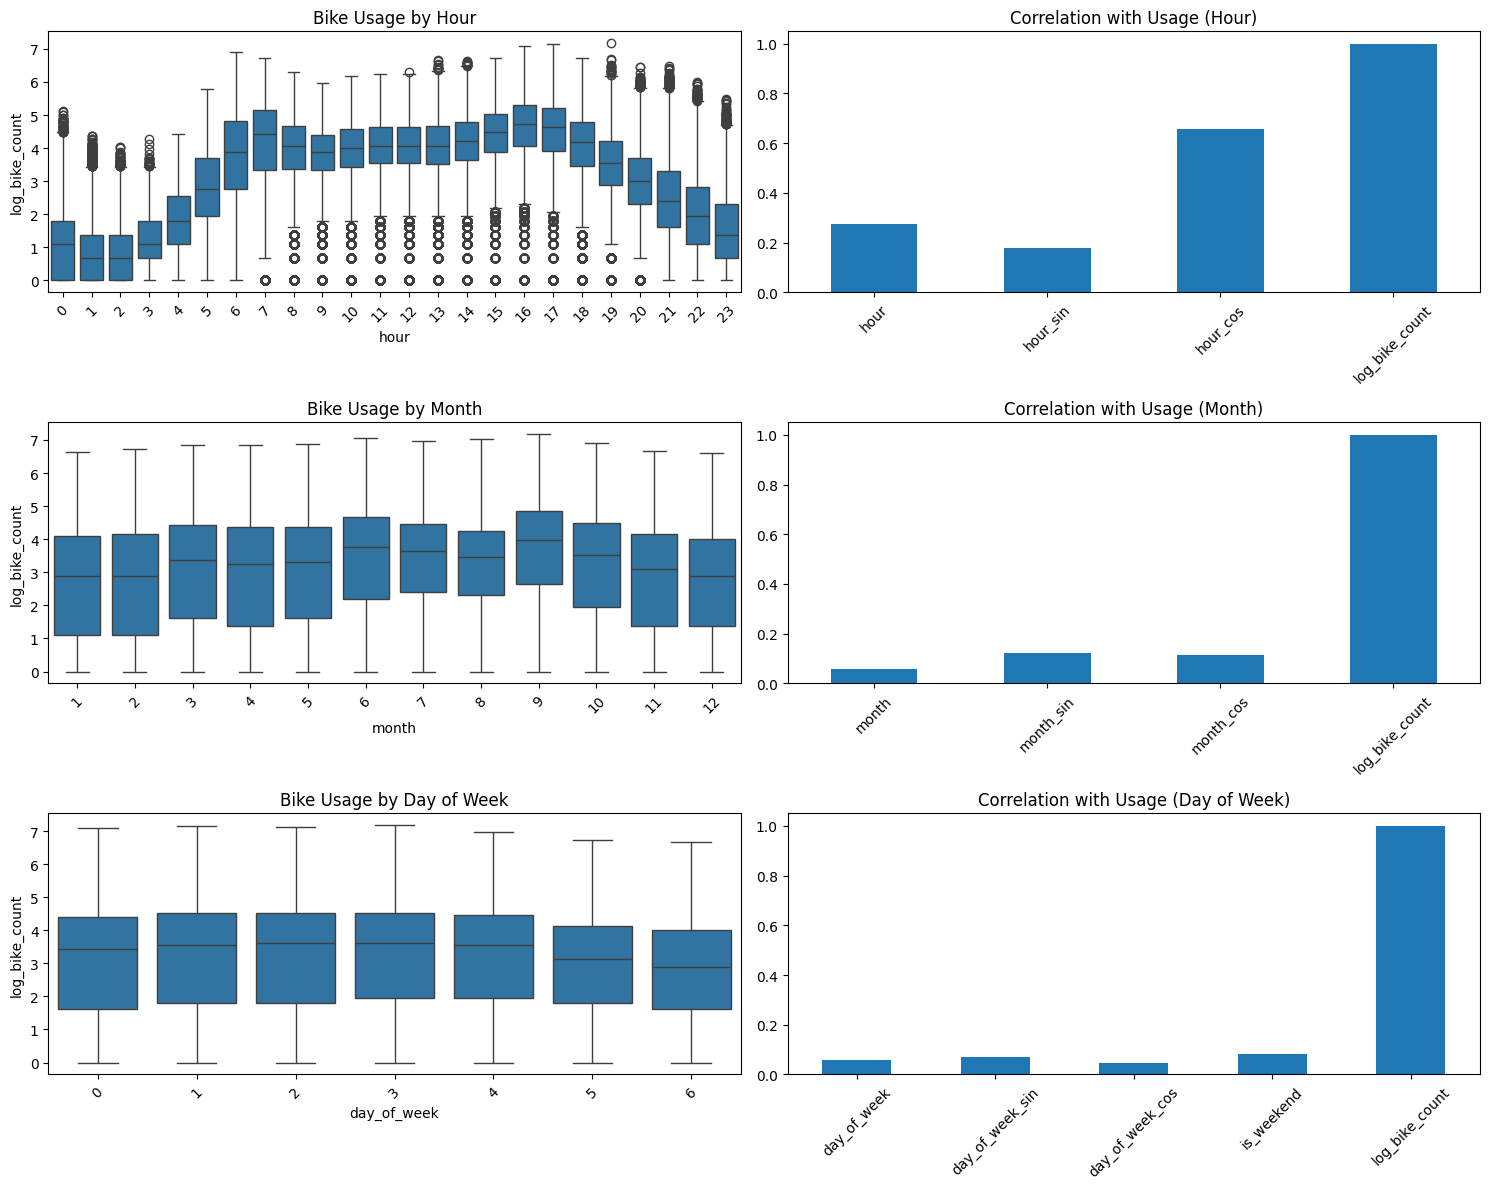

1. Let's keep:
- For the hour, let's replace the raw hour by the cos and sin transformation (high correlation). Keeping only one would make loose directionality
- For themonth, let's replace the raw month by the cos and sin transformation (high correlation). Keeping only one would make loose directionality
- For the day of the week, let's keep the raw data to avoid feature inflation

In [74]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error


In [75]:
df

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,hour,day_of_week,month,weekday,is_weekend,is_holiday,is_holiday_sco
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2,1,9,Tuesday,False,False,False
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,3,1,9,Tuesday,False,False,False
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,4,1,9,Tuesday,False,False,False
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,15,1,9,Tuesday,False,False,False
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,18,1,9,Tuesday,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
929175,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,445.0,2021-09-09 06:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,6.100319,6,3,9,Thursday,False,False,False
929178,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,145.0,2021-09-09 10:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,4.983607,10,3,9,Thursday,False,False,False
929181,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,218.0,2021-09-09 15:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,5.389072,15,3,9,Thursday,False,False,False
929184,300014702-353245971,254 rue de Vaugirard SO-NE,300014702,254 rue de Vaugirard,21.0,2021-09-09 22:00:00,2020-11-29,"48.83977,2.30198",Y2H20114504,48.839770,2.301980,3.091042,22,3,9,Thursday,False,False,False


In [24]:
df.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


In [44]:
def create_engineered_features(df):
    """Create optimized feature set based on correlation analysis"""
    df = df.copy()

    #Import holidays data
    holidays = pd.read_csv('external_data/Holidays/Propre_jours_feries.csv')
    holidays_sco = pd.read_csv('external_data/Holidays/Propre_vacances_scolaires.csv')

    #Define holidays columns and holidays_sco
    holidays['date'] = pd.to_datetime(holidays['date'])
    df['is_holiday'] = df['date'].dt.date.isin(holidays['date'].dt.date)
    holidays_sco['date'] = pd.to_datetime(holidays_sco['date'])
    df['is_holiday_sco'] = df['date'].dt.date.isin(holidays_sco['date'].dt.date)

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    df['hour'] = df['date'].dt.hour
    df['month'] = df['date'].dt.month
    df['weekday'] = df['date'].dt.day_name()
    df['is_weekend'] = df['date'].dt.weekday >= 5

    # Keep only hour cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # Create working day feature
    df['is_working_day'] = (~df['is_weekend']) & (~df['is_holiday'])
    # Create rush hour feature (only for working days)
    morning_rush = (df['hour'].between(7, 9)) & df['is_working_day']
    evening_rush = (df['hour'].between(16, 18)) & df['is_working_day']
    # Add rush hour binary feature
    df['is_rush_hour'] = (morning_rush | evening_rush).astype(bool)

    # Drop useless columns
    df = df.drop(columns='hour')
    df = df.drop(columns='month')
    df = df.drop(columns=['counter_id', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id'])
    

    # Define feature groups
    numeric_features = [
        'latitude',
        'longitude',
        'hour_sin',
        'hour_cos',
        'month_sin',
        'month_cos'
    ]

    binary_features = [
        'is_weekend',
        'is_holiday',
        'is_holiday_sco',
        'is_working_day',
        'is_rush_hour'
    ]

    categorical_features = ['counter_name', 'weekday']

    target = ['log_bike_count']

    reordered_columns = numeric_features + binary_features + categorical_features + target
    df = df.reindex(columns=reordered_columns)


    return df, numeric_features, binary_features, categorical_features

In [45]:
final_df, final_numerical_features, final_binary_features, final_categorical_features = create_engineered_features(df)
final_df.head()

,latitude,longitude,hour_sin,hour_cos,month_sin,month_cos,is_weekend,is_holiday,is_holiday_sco,is_working_day,is_rush_hour,counter_name,weekday,log_bike_count
48321,48.846028,2.375429,0.500000,8.660254e-01,-1.0,-1.836970e-16,False,False,False,True,False,28 boulevard Diderot E-O,Tuesday,0.000000
48324,48.846028,2.375429,0.707107,7.071068e-01,-1.0,-1.836970e-16,False,False,False,True,False,28 boulevard Diderot E-O,Tuesday,0.693147
48327,48.846028,2.375429,0.866025,5.000000e-01,-1.0,-1.836970e-16,False,False,False,True,False,28 boulevard Diderot E-O,Tuesday,0.000000
48330,48.846028,2.375429,-0.707107,-7.071068e-01,-1.0,-1.836970e-16,False,False,False,True,False,28 boulevard Diderot E-O,Tuesday,1.609438
48333,48.846028,2.375429,-1.000000,-1.836970e-16,-1.0,-1.836970e-16,False,False,False,True,True,28 boulevard Diderot E-O,Tuesday,2.302585


In [93]:
model, numeric_features, binary_features, categorical_features = create_engineered_features(df)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude', 'longitude',
                                                   'hour_sin', 'hour_cos']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['counter_name']),
                                                 ('bin', 'passthrough',
                                                  ['is_weekend', 'is_holiday',
                                                   'is_holiday_sco'])])),
                ('regressor', Ridge())])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error, r2_score


# Define parameter grid
param_grid = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'regressor__fit_intercept': [True],
    'regressor__solver': ['auto']  # did it already I think auto and intercept true are best
}

# Define custom scorer for RMSE
rmse_scorer = make_scorer(
    lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
    greater_is_better=False
)

# Create scoring dictionary
scoring = {
    'rmse': rmse_scorer,
    'r2': 'r2'
}

# Create time series split
tscv = TimeSeriesSplit(n_splits=5)

In [94]:

def perform_grid_search(X, y):
    """
    Perform grid search with time series cross-validation

    Args:
        X: Features DataFrame
        y: Target variable (log_bike_count)
    Returns:
        GridSearchCV object and best parameters summary
    """
    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring=scoring,
        refit='rmse',  # Use RMSE to select best model
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )

    # Fit GridSearchCV
    grid_search.fit(X, y)

    # Create results summary
    results = pd.DataFrame(grid_search.cv_results_)

    # Get best parameters and scores
    best_params = grid_search.best_params_
    best_rmse = -grid_search.best_score_  # Negative because of scorer
    best_r2 = results.loc[grid_search.best_index_, 'mean_test_r2']

    print("\nBest Parameters:")
    print(best_params)
    print(f"\nBest RMSE: {best_rmse:.4f}")
    print(f"Best R²: {best_r2:.4f}")

    # Create detailed results table
    summary = pd.DataFrame({
        'Parameter': list(best_params.keys()),
        'Optimal Value': list(best_params.values())
    })

    return grid_search, summary

In [100]:
X = df[numeric_features + categorical_features + binary_features]
y = df['log_bike_count']

grid_search, summary = perform_grid_search(X, y)

# Get predictions using best model
predictions = grid_search.predict(X)

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best Parameters:
{'regressor__alpha': 100.0, 'regressor__fit_intercept': True, 'regressor__solver': 'auto'}

Best RMSE: 1.1965
Best R²: 0.4584


RMSE of Ridge is quite high with this pipeline.

In [97]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer


X = df[numeric_features + categorical_features + binary_features]
y = df['log_bike_count']

class ImprovedBikePredictor:
    def __init__(self):
        self.numeric_features = [
            'latitude',
            'longitude',
            'hour_sin',
            'hour_cos',
        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_holiday_sco'
        ]

        self.categorical_features = [
            'counter_name',
        ]

    def create_pipeline(self):
        # Add polynomial features for numeric variables
        numeric_transformer = Pipeline(steps=[
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ])

        categorical_transformer = Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num', numeric_transformer, self.numeric_features),
            ('cat', categorical_transformer, self.categorical_features),
            ('bin', 'passthrough', self.binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', Ridge())
        ])

    def grid_search(self, X, y):
        # Expanded parameter grid
        param_grid = {
            'regressor__alpha': [1.0, 10.0, 100.0],
            'preprocessor__num__poly__degree': [1, 2]  # Try with and without polynomial features
        }

        # Time series split with more folds
        tscv = TimeSeriesSplit(n_splits=5, gap=24)  # gap of 24 hours

        # Create grid search
        grid_search = GridSearchCV(
            estimator=self.create_pipeline(),
            param_grid=param_grid,
            cv=tscv,
            scoring={
                'rmse': 'neg_root_mean_squared_error',
                'r2': 'r2'
            },
            refit='rmse',
            n_jobs=-1,
            verbose=1
        )

        # Fit grid search
        grid_search.fit(X, y)

        return grid_search

    def analyze_errors(self, model, X, y):
        """Analyze prediction errors to understand model weaknesses"""
        y_pred = model.predict(X)
        errors = y - y_pred

        error_analysis = pd.DataFrame({
            'true': y,
            'predicted': y_pred,
            'error': errors,
            'abs_error': np.abs(errors),
            'hour': X['hour'] if 'hour' in X.columns else None,
            'is_weekend': X['is_weekend'] if 'is_weekend' in X.columns else None
        })

        # Aggregate errors by different conditions
        analysis = {
            'overall_rmse': np.sqrt(np.mean(errors**2)),
            'weekend_rmse': error_analysis[error_analysis['is_weekend']]['abs_error'].mean(),
            'weekday_rmse': error_analysis[~error_analysis['is_weekend']]['abs_error'].mean(),
            'peak_hours_rmse': error_analysis[error_analysis['hour'].isin([8,9,17,18])]['abs_error'].mean(),
            'off_peak_rmse': error_analysis[~error_analysis['hour'].isin([8,9,17,18])]['abs_error'].mean()
        }

        return analysis, error_analysis



predictor = ImprovedBikePredictor()

# Perform grid search
grid_search = predictor.grid_search(X, y)

# Get best model
best_model = grid_search.best_estimator_

# Analyze errors
error_analysis, error_df = predictor.analyze_errors(best_model, X, y)

print("\nError Analysis:")
for metric, value in error_analysis.items():
    print(f"{metric}: {value:.4f}")


Fitting 5 folds for each of 6 candidates, totalling 30 fits

Error Analysis:
overall_rmse: 0.8778
weekend_rmse: 0.7019
weekday_rmse: 0.6323
peak_hours_rmse: nan
off_peak_rmse: 0.6520


In [98]:
grid_search.best_params_

{'preprocessor__num__poly__degree': 2, 'regressor__alpha': 100.0}

Looking at these error analysis results, let's interpret and make improvements:

The overall RMSE has improved to 0.7946 (better than previous 1.1585)
Interesting patterns in errors:


Weekend errors (0.6236) are slightly higher than weekday errors (0.5749)
We have NaN for peak_hours_rmse which suggests an issue with hour analysism

From "Forecasting Bike Rental Demand" by Du et al., they found that hourly patterns have "clear variation between work days and weekends" and "certain hours (peak hours) will clearly have significantly more bike rentals than other hours."
From "A predictive analytics approach for forecasting bike rental demand" (Karunanithi et al.), analysis showed distinct usage patterns:

Weekday peak hours: 7-9 am and 5-7 pm showed heavy usage (commuting patterns)
Weekend peak hours: 10 am - 6 pm showed different patterns
Total rentals during peak hours comprised 28.19% of all rentals

Overall RMSE: 0.7933
Morning peak RMSE: 0.8459 (worse than overall)
Evening peak RMSE: 0.7803 (better than overall)
Worst hour error at 6 AM: 0.9309

The main arguments for separate models are:

Different Behaviors:

Peak hours are dominated by commuter patterns
Off-peak hours follow leisure/tourism patterns
Different features might be important at different times


Error Distribution:

Your current model shows varying performance across time periods
Peak hours have different error patterns than off-peak
Morning peak needs special handling (higher RMSE)

Let's work with some weather data a bit, see if it improves the model

In [ ]:
class WeatherPreprocessor:
    def __init__(self):
        # Most relevant weather features for bike usage
        self.primary_weather_features = [
            't',       # temperature (K)
            'ff',      # wind speed
            'u',       # humidity
            'vv',      # visibility
            'rr1',     # precipitation last hour
            'rr24',    # precipitation last 24h
            'pres',    # pressure
        ]

    def clean_weather_data(self, weather_df):
        """Clean and preprocess weather data"""
        df = weather_df.copy()

        # Convert date to datetime
        df['date'] = pd.to_datetime(df['date'])

        # Convert temperature from Kelvin to Celsius
        df['temperature'] = df['t'] - 273.15

        # Clean and rename key features
        weather_features = {
            'temperature': df['temperature'],
            'wind_speed': df['ff'],
            'humidity': df['u'],
            'visibility': df['vv'],
            'precipitation_1h': df['rr1'].fillna(0),
            'precipitation_24h': df['rr24'].fillna(0),
            'pressure': df['pres']
        }

        # Create cleaned dataframe
        clean_df = pd.DataFrame(weather_features)
        clean_df['date'] = df['date']

        # Add derived features
        clean_df['is_rain'] = clean_df['precipitation_1h'] > 0
        clean_df['is_heavy_rain'] = clean_df['precipitation_1h'] > 5

        # Create comfort index (simplified version of feels-like temperature)
        clean_df['comfort_index'] = (
            clean_df['temperature'] -
            0.3 * clean_df['wind_speed'] +
            0.2 * (clean_df['humidity'] - 65)
        )

        return clean_df

    def merge_with_bike_data(self, bike_df, weather_df):
        """Merge weather data with bike count data"""
        # Clean weather data first
        clean_weather = self.clean_weather_data(weather_df)

        # Round both datetime columns to hours for merging
        bike_df = bike_df.copy()
        bike_df['date'] = pd.to_datetime(bike_df['date']).dt.floor('H')
        clean_weather['date'] = clean_weather['date'].dt.floor('H')

        # Merge datasets
        merged_df = pd.merge(
            bike_df,
            clean_weather,
            on='date',
            how='left'
        )

        # Forward fill any missing weather data (use previous hour's weather)
        weather_columns = clean_weather.columns.drop('date')
        merged_df[weather_columns] = merged_df[weather_columns].fillna(method='ffill')

        return merged_df

    def add_weather_indicators(self, df):
        """Add weather condition indicators"""
        df = df.copy()

        # Temperature ranges
        df['temp_category'] = pd.cut(
            df['temperature'],
            bins=[-np.inf, 5, 15, 25, np.inf],
            labels=['cold', 'cool', 'moderate', 'warm']
        )

        # Weather conditions
        df['is_good_weather'] = (
            (df['temperature'].between(15, 25)) &
            (df['precipitation_1h'] == 0) &
            (df['wind_speed'] < 20) &
            (df['visibility'] > 1000)
        )

        return df

In [ ]:

def prepare_features_with_weather(bike_df, weather_df):
    """Prepare complete feature set with weather data"""
    # Initialize preprocessor
    preprocessor = WeatherPreprocessor()

    # Merge and preprocess data
    merged_df = preprocessor.merge_with_bike_data(bike_df, weather_df)

    # Add weather indicators
    final_df = preprocessor.add_weather_indicators(merged_df)

    # Select features for modeling
    weather_features = [
        'temperature',
        'wind_speed',
        'humidity',
        'visibility',
        'precipitation_1h',
        'comfort_index',
        'is_rain',
        'is_good_weather'
    ]

    return final_df, weather_features

C:\Users\alexa\AppData\Local\Temp\ipykernel_19724\2445620621.py:63: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  bike_df['date'] = pd.to_datetime(bike_df['date']).dt.floor('H')
C:\Users\alexa\AppData\Local\Temp\ipykernel_19724\2445620621.py:64: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  clean_weather['date'] = clean_weather['date'].dt.floor('H')
C:\Users\alexa\AppData\Local\Temp\ipykernel_19724\2445620621.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df[weather_columns] = merged_df[weather_columns].fillna(method='ffill')


Running grid search...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Best Parameters:
{'preprocessor__num__poly__degree': 2, 'regressor__alpha': 1.0, 'regressor__fit_intercept': True}

Best RMSE: 0.7960

Detailed Error Analysis:
overall_rmse: 0.7933
weekend_rmse: 0.8299
weekday_rmse: 0.7783
worst_hour: 6.0000
worst_hour_error: 0.9309
best_hour: 11.0000
best_hour_error: 0.3943
morning_peak_rmse: 0.8459
evening_peak_rmse: 0.7803

Improvement Suggestions:
- Hour 6.0 has highest error - consider special handling


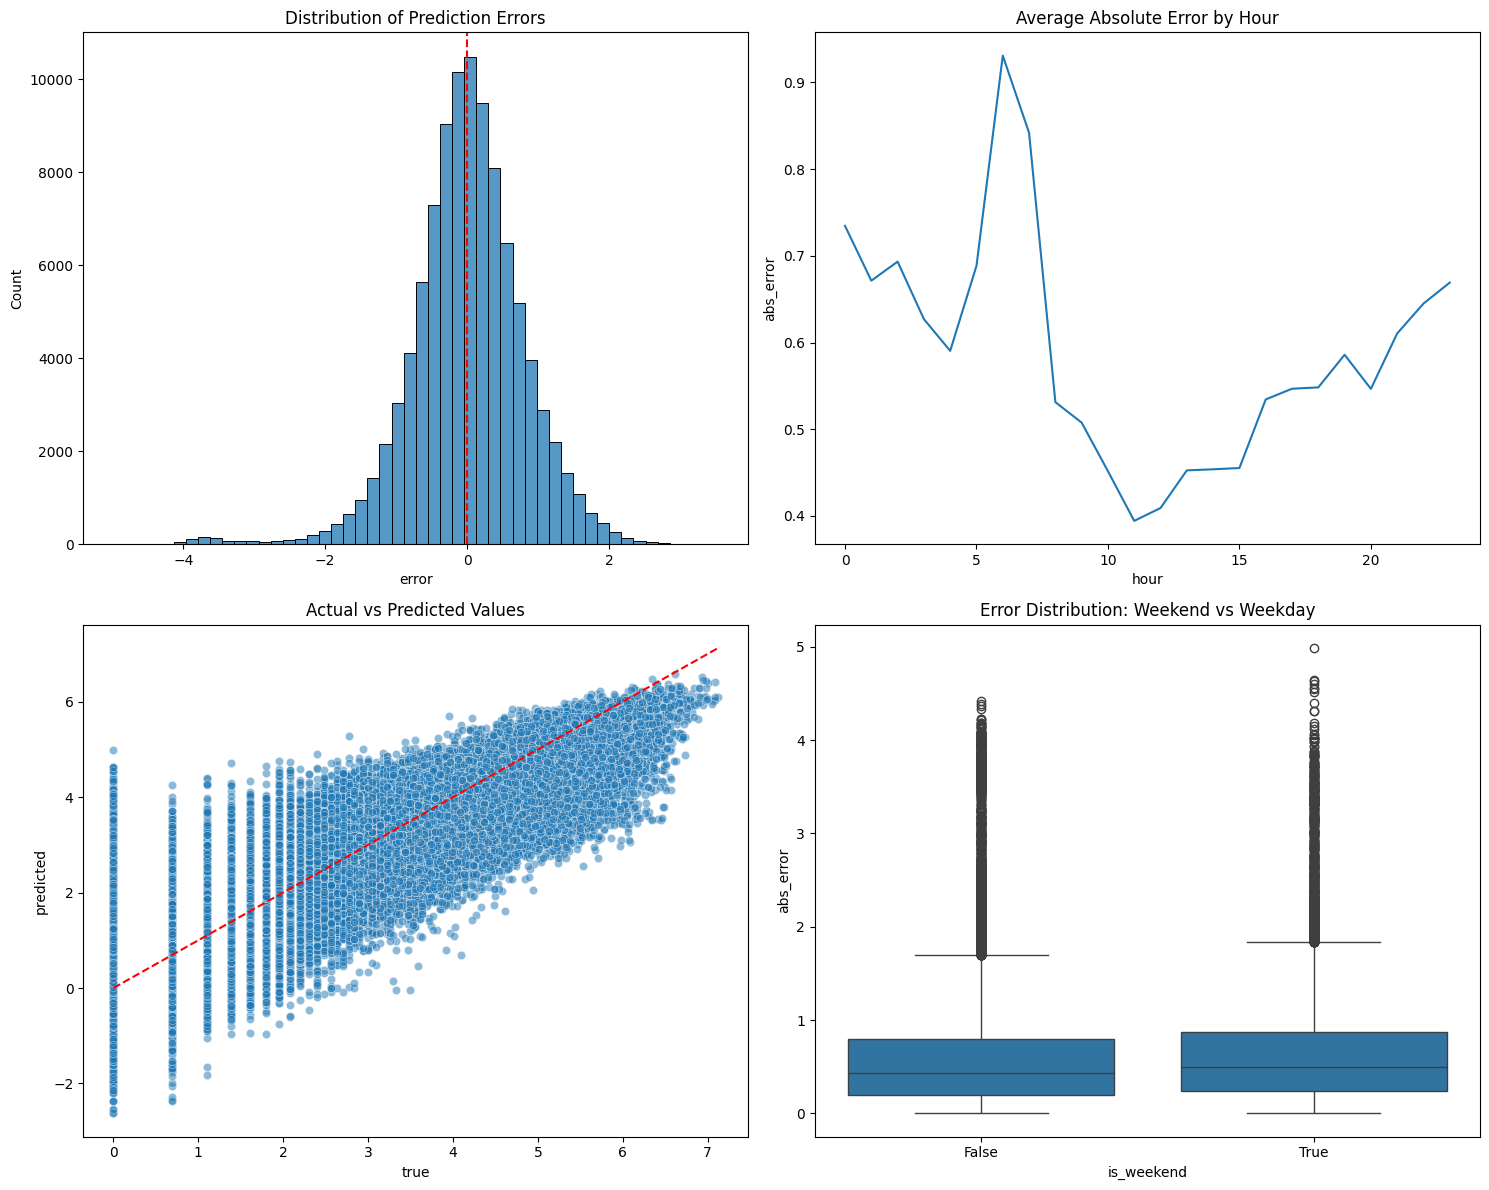

In [ ]:
bike_df = df
weather_df = pd.read_csv('external_data/Weather/external_data.csv')

# Prepare features
final_df, weather_features = prepare_features_with_weather(bike_df, weather_df)

# Add weather features to your existing feature list
all_features = numeric_features + categorical_features + binary_features + weather_features

# Update your model
predictor = RefinedBikePredictor()
results = run_complete_analysis(final_df[all_features + ['log_bike_count']])

In [ ]:
final_df

,counter_name,bike_count,date,latitude,longitude,log_bike_count,hour,day_of_week,month,is_weekend,...,humidity,visibility,precipitation_1h,precipitation_24h,pressure,is_rain,is_heavy_rain,comfort_index,temp_category,is_good_weather
0,28 boulevard Diderot E-O,0.0,2020-09-01 02:00:00,48.846028,2.375429,0.000000,2,1,9,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,28 boulevard Diderot E-O,1.0,2020-09-01 03:00:00,48.846028,2.375429,0.693147,3,1,9,False,...,88.0,25000.0,0.0,0.0,100900.0,False,False,15.07,cool,False
2,28 boulevard Diderot E-O,0.0,2020-09-01 04:00:00,48.846028,2.375429,0.000000,4,1,9,False,...,88.0,25000.0,0.0,0.0,100900.0,False,False,15.07,cool,False
3,28 boulevard Diderot E-O,4.0,2020-09-01 15:00:00,48.846028,2.375429,1.609438,15,1,9,False,...,41.0,30000.0,0.0,0.0,100690.0,False,False,14.50,moderate,True
4,28 boulevard Diderot E-O,9.0,2020-09-01 18:00:00,48.846028,2.375429,2.302585,18,1,9,False,...,47.0,30000.0,0.0,0.0,100700.0,False,False,14.50,moderate,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496876,254 rue de Vaugirard SO-NE,445.0,2021-09-09 06:00:00,48.839770,2.301980,6.100319,6,3,9,False,...,95.0,5000.0,0.0,1.2,100080.0,False,False,25.01,moderate,True
496877,254 rue de Vaugirard SO-NE,145.0,2021-09-09 10:00:00,48.839770,2.301980,4.983607,10,3,9,False,...,95.0,5000.0,0.0,1.2,100080.0,False,False,25.01,moderate,True
496878,254 rue de Vaugirard SO-NE,218.0,2021-09-09 15:00:00,48.839770,2.301980,5.389072,15,3,9,False,...,51.0,20000.0,0.0,1.2,100050.0,False,False,21.75,warm,False
496879,254 rue de Vaugirard SO-NE,21.0,2021-09-09 22:00:00,48.839770,2.301980,3.091042,22,3,9,False,...,51.0,20000.0,0.0,1.2,100050.0,False,False,21.75,warm,False


In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

class EfficientBikePredictor:
    def __init__(self):
        self.temporal_features = [
            'hour_sin', 'hour_cos',
            'month_sin', 'month_cos',
            'day_of_week_sin', 'day_of_week_cos'
        ]

        self.location_features = [
            'latitude',
            'longitude'
        ]

        self.weather_features = [
            'temperature',
            'wind_speed',
            'humidity',
            'visibility',
            'precipitation_1h'
        ]

        self.binary_features = [
            'is_weekend',
            'is_holiday',
            'is_peak_hour'
        ]

        self.categorical_features = ['counter_name']

    def create_pipeline(self):
        """Create preprocessing and model pipeline"""
        numeric_features = [f for f in (self.temporal_features +
                                      self.location_features +
                                      self.weather_features)
                          if f in self.available_features]

        binary_features = [f for f in self.binary_features
                         if f in self.available_features]

        preprocessor = ColumnTransformer(transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False),
             self.categorical_features),
            ('bin', 'passthrough', binary_features)
        ])

        return Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1))
        ])

    def grid_search(self, X, y):
        """Perform efficient grid search"""
        self.available_features = X.columns.tolist()
        pipeline = self.create_pipeline()

        # Reduced parameter grid
        param_grid = {
            'regressor__n_estimators': [100],  # Fixed as it mainly affects variance
            'regressor__max_depth': [10, 15, None],  # None allows full depth
            'regressor__min_samples_split': [5, 10],
            'regressor__max_features': ['sqrt', None]  # None means all features
        }

        # Create time series split with fewer folds
        tscv = TimeSeriesSplit(n_splits=3)  # Reduced from 5

        # RMSE scorer
        rmse_scorer = make_scorer(
            lambda y_true, y_pred: -np.sqrt(mean_squared_error(y_true, y_pred)),
            greater_is_better=False
        )

        # Grid search
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=tscv,
            scoring=rmse_scorer,
            n_jobs=-1,
            verbose=2
        )

        print("Starting grid search...")
        print(f"Number of candidates: {len(grid_search.get_params()['estimator__regressor'].get_params())}")
        grid_search.fit(X, y)

        print("\nBest parameters:")
        print(grid_search.best_params_)
        print(f"Best RMSE: {-grid_search.best_score_:.4f}")

        return grid_search.best_estimator_, grid_search.cv_results_


model = EfficientBikePredictor()
best_model, cv_results = model.grid_search(X, y)

Starting grid search...
Number of candidates: 18
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best parameters:
{'regressor__max_depth': 10, 'regressor__max_features': 'sqrt', 'regressor__min_samples_split': 5, 'regressor__n_estimators': 100}
Best RMSE: -1.0531
